# Deadly Visualizations!!!

![Image](../images/viz_types_portada.png)

## Setup

First we need to create a basic setup which includes:

- Importing the libraries.

- Reading the dataset file (source [Instituto Nacional de Estadística](https://www.ine.es/ss/Satellite?L=es_ES&c=Page&cid=1259942408928&p=1259942408928&pagename=ProductosYServicios%2FPYSLayout)).

- Create a couple of columns and tables for the analysis.

__NOTE:__ some functions were already created in order to help you go through the challenge. However, feel free to perform any code you might need.

In [13]:
# some imports

import sys
sys.path.insert(0, "../modules")
import pandas as pd
import cufflinks as cf
import plotly.express as px
import re
import module as mod # functions are include in module.py.
cf.go_offline()

In [14]:
# read dataset

deaths = pd.read_csv('../data/7947.csv', sep=';', thousands='.')

deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301158 entries, 0 to 301157
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Causa de muerte  301158 non-null  object
 1   Sexo             301158 non-null  object
 2   Edad             301158 non-null  object
 3   Periodo          301158 non-null  int64 
 4   Total            301158 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.5+ MB


In [15]:
# add some columns...you'll need them later

deaths['cause_code'] = deaths['Causa de muerte'].apply(mod.cause_code)
deaths['cause_group'] = deaths['Causa de muerte'].apply(mod.cause_types)
deaths['cause_name'] = deaths['Causa de muerte'].apply(mod.cause_name)

deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301158 entries, 0 to 301157
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Causa de muerte  301158 non-null  object
 1   Sexo             301158 non-null  object
 2   Edad             301158 non-null  object
 3   Periodo          301158 non-null  int64 
 4   Total            301158 non-null  int64 
 5   cause_code       301158 non-null  object
 6   cause_group      301158 non-null  object
 7   cause_name       301158 non-null  object
dtypes: int64(2), object(6)
memory usage: 18.4+ MB


In [16]:
# lets check the categorical variables

var_list = ['Sexo', 'Edad', 'Periodo', 'cause_code', 'cause_name', 'cause_group']

categories = mod.cat_var(deaths, var_list)
categories

,categorical_variable,number_of_possible_values,values
0,cause_code,117,"[001-102, 001-008, 001, 002, 003, 004, 005, 00..."
1,cause_name,117,"[I-XXII.Todas las causas, I.Enfermedades infec..."
2,Periodo,39,"[2018, 2017, 2016, 2015, 2014, 2013, 2012, 201..."
3,Edad,22,"[Todas las edades, Menos de 1 año, De 1 a 4 añ..."
4,Sexo,3,"[Total, Hombres, Mujeres]"
5,cause_group,2,"[Multiple causes, Single cause]"


In [17]:
# we need also to create a causes table for the analysis

causes_table = deaths[['cause_code', 'cause_name']].drop_duplicates().sort_values(by='cause_code').reset_index(drop=True)

causes_table

,cause_code,cause_name
0,001,Enfermedades infecciosas intestinales
1,001-008,I.Enfermedades infecciosas y parasitarias
2,001-102,I-XXII.Todas las causas
3,002,Tuberculosis y sus efectos tardíos
4,003,Enfermedad meningocócica
...,...,...
112,098,Suicidio y lesiones autoinfligidas
113,099,Agresiones (homicidio)
114,100,Eventos de intención no determinada
115,101,Complicaciones de la atención médica y quirúrgica


In [18]:
# And some space for free-style Pandas!!!








## Lets make some transformations

Eventhough the dataset is pretty clean, the information is completely denormalized as you could see. For that matter a collection of methods (functions) are available in order to generate the tables you might need:

- `row_filter(df, cat_var, cat_values)` => Filter rows by any value or group of values in a categorical variable.

- `nrow_filter(df, cat_var, cat_values)` => The same but backwards. 

- `groupby_sum(df, group_vars, agg_var='Total', sort_var='Total')` => Add deaths by a certain variable.

- `pivot_table(df, col, x_axis, value='Total')`=> Make some pivot tables, you might need them...

In [19]:
# Setup methods

def cat_var(df, cols):
    cat_list = []
    for col in cols:
        cat = df[col].unique()
        cat_num = len(cat)
        cat_dict = {"categorical_variable":col,
                    "number_of_possible_values":cat_num,
                    "values":cat}
        cat_list.append(cat_dict)
    df = pd.DataFrame(cat_list).sort_values(by="number_of_possible_values", ascending=False)
    return df.reset_index(drop=True)

def cause_types(cause):
    pattern = '\d+-\d+'
    x = re.findall(pattern, cause)
    if len(x) == 0:
        return 'Single cause'
    else:
        return 'Multiple causes'

def cause_code(text):
    return text.split(" ", 1)[0]

def cause_name(text):
    return text.split(" ", 1)[1].strip()


# Transformation methods

#cat_values = list

def row_filter(df, cat_var, cat_values):
    df = df[df[cat_var].isin(cat_values)].sort_values(by='Total', ascending=False)
    return df.reset_index(drop=True)

def nrow_filter(df, cat_var, cat_values):
    df = df[~df[cat_var].isin(cat_values)].sort_values(by='Total', ascending=False)
    return df.reset_index(drop=True)

def groupby_sum(df, group_vars, agg_var='Total', sort_var='Total'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'sum'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

def pivot_table(df, col, x_axis, value='Total'):
    df = df.pivot_table(values=value,
                        columns=col,
                        index=x_axis,
                        aggfunc='sum')
    return df.reset_index()

## ...and finally, show me some insights with Plotly!!!

Of course, you can always check the [class notes](https://github.com/whiteboxml/teaching-ironhack-dataptmad-2011/tree/main/week_11/interactive_data_visualization) for further info. 

In [ ]:
# Cufflinks histogram

dataset_column.iplot(kind='hist',
                     title='VIZ TITLE',
                     yTitle='AXIS TITLE',
                     xTitle='AXIS TITLE')

In [ ]:
# Cufflinks bar plot

dataset_bar.iplot(kind='bar',
                  x='VARIABLE',
                  xTitle='AXIS TITLE',
                  yTitle='AXIS TITLE',
                  title='VIZ TITLE')

In [ ]:
# Cufflinks line plot

dataset_line.iplot(kind='line',
                   x='VARIABLE',
                   xTitle='AXIS TITLE',
                   yTitle='AXIS TITLE',
                   title='VIZ TITLE')

In [ ]:
# Cufflinks scatter plot

dataset_scatter.iplot(x='VARIABLE', 
                      y='VARIABLE', 
                      categories='VARIABLE',
                      xTitle='AXIS TITLE', 
                      yTitle='AXIS TITLE',
                      title='VIZ TITLE')

### INSIGHTS WITH PLOTLY

In [27]:
deaths[deaths['cause_code'] == '102']

,Causa de muerte,Sexo,Edad,Periodo,Total,cause_code,cause_group,cause_name
298584,102 Otras causas externas y sus efectos tardíos,Total,Todas las edades,2018,79,102,Single cause,Otras causas externas y sus efectos tardíos
298585,102 Otras causas externas y sus efectos tardíos,Total,Todas las edades,2017,90,102,Single cause,Otras causas externas y sus efectos tardíos
298586,102 Otras causas externas y sus efectos tardíos,Total,Todas las edades,2016,71,102,Single cause,Otras causas externas y sus efectos tardíos
298587,102 Otras causas externas y sus efectos tardíos,Total,Todas las edades,2015,74,102,Single cause,Otras causas externas y sus efectos tardíos
298588,102 Otras causas externas y sus efectos tardíos,Total,Todas las edades,2014,64,102,Single cause,Otras causas externas y sus efectos tardíos
...,...,...,...,...,...,...,...,...
301153,102 Otras causas externas y sus efectos tardíos,Mujeres,95 y más años,1984,0,102,Single cause,Otras causas externas y sus efectos tardíos
301154,102 Otras causas externas y sus efectos tardíos,Mujeres,95 y más años,1983,0,102,Single cause,Otras causas externas y sus efectos tardíos
301155,102 Otras causas externas y sus efectos tardíos,Mujeres,95 y más años,1982,0,102,Single cause,Otras causas externas y sus efectos tardíos
301156,102 Otras causas externas y sus efectos tardíos,Mujeres,95 y más años,1981,0,102,Single cause,Otras causas externas y sus efectos tardíos


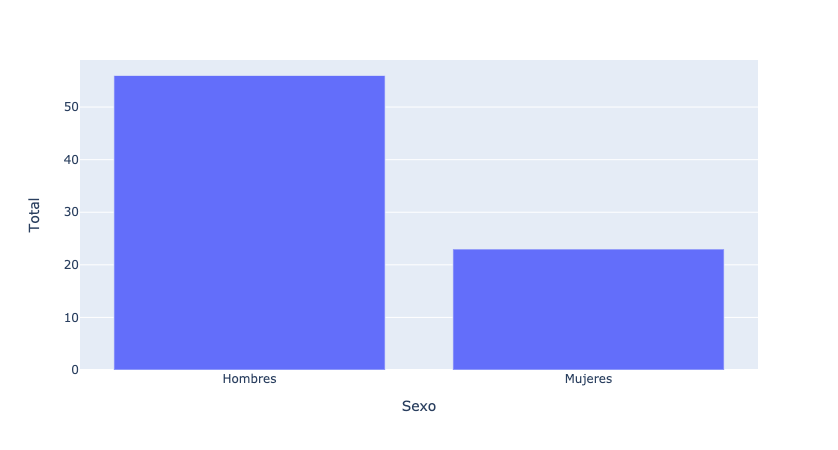

In [50]:
# muertes de hombres por causa 102 en 2018
deaths_102_2018 = deaths[(deaths['Edad'] == 'Todas las edades') & ((deaths['Sexo'] == 'Hombres') | (deaths['Sexo'] == 'Mujeres')) & (deaths['Periodo'] == 2018) & (deaths['cause_code'] == '102')]


# number of woman vs men died for cause 102 (Otras causas externas y sus efectos tardíos) in 2018
px.bar(data_frame=deaths_102_2018, x='Sexo', y='Total')

In [41]:
# muertes hombres y mujeres cada año de todas las edades
df_sin_totalsexo = row_filter(deaths,'Sexo', ('Mujeres', 'Hombres'))
df_sin_multiplecauses = row_filter(deaths,'cause_group', ('Mujeres', 'Hombres'))

,Causa de muerte,Sexo,Edad,Periodo,Total,cause_code,cause_group,cause_name
0,001-102 I-XXII.Todas las causas,Hombres,Todas las edades,2018,216442,001-102,Multiple causes,I-XXII.Todas las causas
1,001-102 I-XXII.Todas las causas,Hombres,Todas las edades,2017,214236,001-102,Multiple causes,I-XXII.Todas las causas
2,001-102 I-XXII.Todas las causas,Hombres,Todas las edades,2015,213309,001-102,Multiple causes,I-XXII.Todas las causas
3,001-102 I-XXII.Todas las causas,Mujeres,Todas las edades,2018,211279,001-102,Multiple causes,I-XXII.Todas las causas
4,001-102 I-XXII.Todas las causas,Mujeres,Todas las edades,2017,210287,001-102,Multiple causes,I-XXII.Todas las causas
...,...,...,...,...,...,...,...,...
199827,078 Enfermedades de los órganos genitales mas...,Mujeres,Todas las edades,2011,0,078,Single cause,Enfermedades de los órganos genitales masculinos
199828,078 Enfermedades de los órganos genitales mas...,Mujeres,Todas las edades,2010,0,078,Single cause,Enfermedades de los órganos genitales masculinos
199829,078 Enfermedades de los órganos genitales mas...,Mujeres,Todas las edades,2009,0,078,Single cause,Enfermedades de los órganos genitales masculinos
199830,078 Enfermedades de los órganos genitales mas...,Mujeres,Todas las edades,2008,0,078,Single cause,Enfermedades de los órganos genitales masculinos


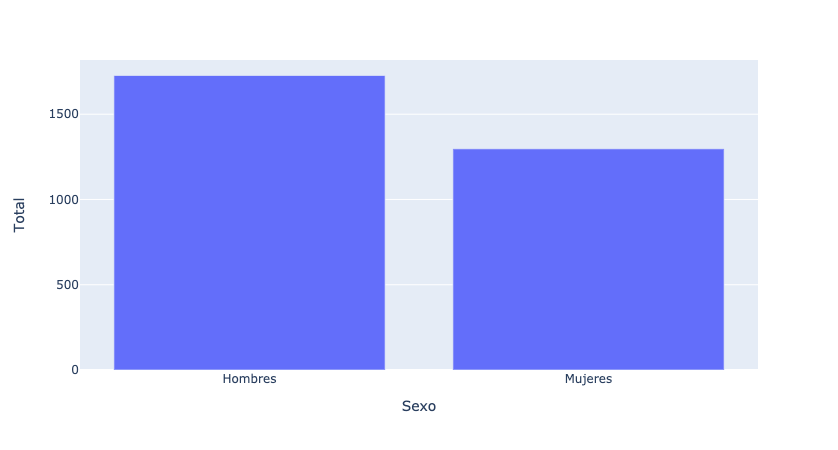

In [48]:
# Total de muertos cada año por 'Tumor maligno del encéfalo'
df_tumor = df_sin_totalsexo[(df_sin_totalsexo['cause_name'] == 'Tumor maligno del encéfalo') & (df_sin_totalsexo['Periodo'] == 2018) & (df_sin_totalsexo['Edad'] == 'Todas las edades')]

#graph
px.bar(data_frame=df_tumor, x='Sexo', y='Total')

In [ ]:
# total de muertes por cada causa en 2018

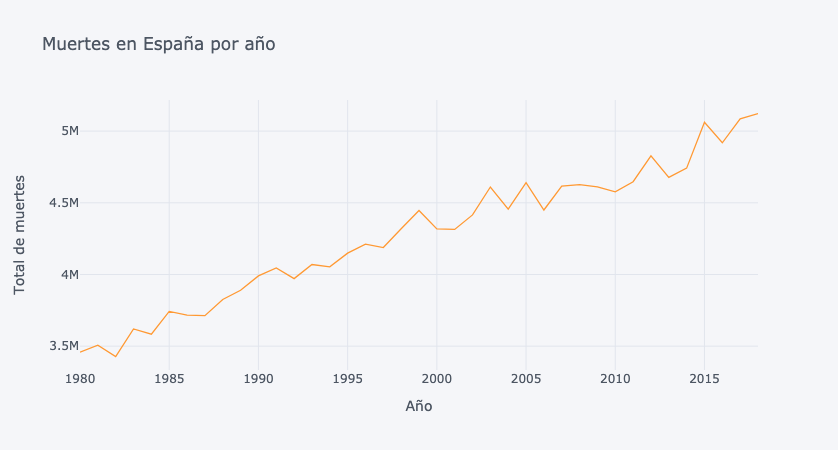

In [52]:
deaths_line = deaths.groupby('Periodo')['Total'].sum().to_frame().reset_index()
deaths_line.iplot(kind='line',
                   x='Periodo',
                   xTitle='Año',
                   yTitle='Total de muertes',
                   title='Muertes en España por año')